In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import gray2rgb
import cv2
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from fd import get_file_list
from plotting import plot_face_bb

Using gpu device 0: GeForce GTX 960


In [4]:
train_folder = '/home/arya_03/data/faceScrub/train/'

In [6]:
fnames, bboxes = get_file_list(train_folder)

In [7]:
fnames[0], bboxes[0]

('/home/arya_03/data/faceScrub/train/Charlie_Day/ceb30b3be359b8e424b52421b7f6e40ca7af94d8d3de42037d687cfdc6ed8d51.jpg',
 [0.252, 0.268, 0.736, 0.753])

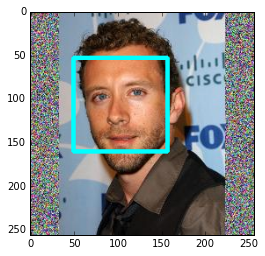

In [13]:
plot_face_bb(fnames[1000], bboxes[1000])

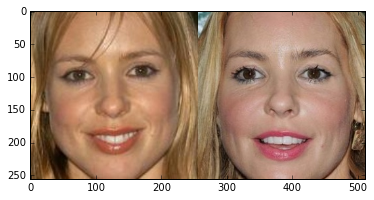

In [11]:
plt.imshow(imread('/home/arya_03/data/concat/1/bb0045a7e4e979084ea1b3677a03df10.jpg'))